In [20]:
library(tidyverse)
library(DESeq2)
library(BiocParallel)
library(RColorBrewer)
library(pheatmap)
library(umap)
library(cowplot)
library(ggplotify)
library(grid)

# Custom package
library(rutils)

In [2]:
n_cores <- detectCores() - 2
BiocParallel::register(MulticoreParam(n_cores))

In [3]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
gyn_projects <- c("CESC", "UCS", "UCEC", "OV")
# nongyn_projects <- c("TCGA-BRCA", "TCGA-COAD", "TCGA-LGG")
nongyn_projects <- c("BRCA", "COAD", "TGCT", "PRAD")
pan_projects <- c(gyn_projects, nongyn_projects)

# Load data

In [4]:
pan_coldata_df <- read_tsv(paste0(dirs$data_dir, "/TCGA_RNA_combined_matrix_count_data/matrisome_pan_coldata.tsv")) %>%
    dplyr::mutate(project_short = substring(project, 6)) %>%
    dplyr::select(-project) %>%
    dplyr::rename(project = project_short)
pan_counts_df <- read_tsv(paste0(dirs$data_dir, "/TCGA_RNA_combined_matrix_count_data/prefiltered_norm_matrisome_pan_counts.tsv")) %>%
    dplyr::select(-ensembl_gene_id)


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  sample_name = col_character(),
  condition = col_character(),
  project = col_character()
)



-- Column specification ------------------------------------------------------------------------------------------------
cols(
  .default = col_double(),
  ensembl_gene_id = col_character(),
  external_gene_name = col_character()
)
i Use `spec()` for the full column specifications.




In [5]:
gyn_coldata_df <- read_tsv(paste0(dirs$data_dir, "/TCGA_RNA_combined_matrix_count_data/matrisome_gyn_coldata.tsv")) %>%
    dplyr::mutate(project_short = substring(project, 6)) %>%
    dplyr::select(-project) %>%
    dplyr::rename(project = project_short)
gyn_counts_df <- read_tsv(paste0(dirs$data_dir, "/TCGA_RNA_combined_matrix_count_data/prefiltered_norm_matrisome_gyn_counts.tsv")) %>%
    dplyr::select(-ensembl_gene_id)


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  sample_name = col_character(),
  condition = col_character(),
  project = col_character()
)



-- Column specification ------------------------------------------------------------------------------------------------
cols(
  .default = col_double(),
  ensembl_gene_id = col_character(),
  external_gene_name = col_character()
)
i Use `spec()` for the full column specifications.




In [120]:
text_size <- 11
guide_size <- 1
family <- "arial"
dpi <- 320
hm_ht <- 5
hm_wd <- 6
scree_ht <- 3
scree_wd <- 4
pca_ht <- 4
pca_wd <- 6
sm_ht <- 4
sm_wd <- 5
umap_ht <- 4
umap_wd <- 6

In [116]:
get_pca_results <- function(counts, coldata_df) {
    pca_res <- prcomp(t(counts), center = TRUE, scale. = FALSE)
    
    pca_res_df <- pca_res$x %>%
        as_tibble(rownames = "sample_name") %>%
        mutate(project = coldata_df$project) %>%
        dplyr::select(sample_name, project, everything())
    
    pca_var_df <- tibble(pc = colnames(pca_res$x)) %>%
        mutate(var = pca_res$sdev ^ 2) %>%
        mutate(pct_var = round(var / sum(var) * 100, 1)) %>%
        mutate(pc_fact = factor(colnames(pca_res$x), levels = colnames(pca_res$x)))
    
    return(list(
        res = pca_res_df,
        var = pca_var_df
    ))
}

get_umap_results <- function(counts, coldata_df, random_state) {
    res_umap <- umap(t(counts), random_state = random_state)
    
    colnames(res_umap$layout) <- c("x1", "x2")
    umap_df <- res_umap$layout %>%
        as_tibble() %>%
        bind_cols(coldata_df)
    return(umap_df)
}

pca_scatter <- function(df, pc_x, pc_y, pc_x_pctvar, pc_y_pctvar, col, legend_title = NULL, breaks = FALSE, values = FALSE, pt_size = 0.5, legend_color_size = 6, hide_legend = FALSE) {
    plt <- ggplot(df) +
        aes_string(x = pc_x, y = pc_y, color = col) +
        geom_point(size = pt_size) +
        {if(breaks != FALSE && values != FALSE) scale_color_manual(breaks = breaks, values = values) } +
        guides(color = guide_legend(title = legend_title, override.aes = list(size = legend_color_size))) +
        theme_classic() +
        theme(
            text = element_text(size = text_size, family = family),
        ) +
        {if(hide_legend) theme(legend.position = "none")} +
        labs(x = paste0(pc_x, " (", pc_x_pctvar, "%)"), y = paste0(pc_y, " (", pc_y_pctvar, "%)"))
    return(plt)
}

umap_scatter <- function(df, umap_x, umap_y, col, legend_title = NULL, breaks = FALSE, values = FALSE, hide_legend = FALSE, pt_size = 0.5, legend_color_size = 6, jitter_w = 0.1, jitter_h = 0.1, seed = 123) {
    plt <- ggplot(df) +
        aes_string(x = umap_x, y = umap_y, color = col) +
        geom_point(size = pt_size, position = position_jitter(w = jitter_w, h = jitter_h, seed = seed)) +
        {if(breaks != FALSE && values != FALSE) scale_color_manual(breaks = breaks, values = values) } +
        guides(color = guide_legend(title = legend_title, override.aes = list(size = legend_color_size))) +
        theme_classic() +
        theme(
            text = element_text(size = text_size, family = family),
        ) +
        {if(hide_legend) theme(legend.position = "none")} +
        labs(x = "x", y = "y")
    return(plt)
}

plot_hm <- function(hm, dest) {
    png(dest)
    grid::grid.newpage()
    grid::grid.draw(hm$gtable)
    dev.off()
}

# Heatmaps

## Get representative group samples

In [8]:
gyn_centroids <- get_group_centroids(
    gyn_counts_df, gyn_coldata_df, gyn_projects, "project", "sample_name"
)

pan_centroids <- get_group_centroids(
    pan_counts_df, pan_coldata_df, pan_projects, "project", "sample_name"
)

In [33]:
gyn_coldata_df %>%
    group_by(project) %>%
    summarize(n = n())

,project,n
,<chr>,<int>
1,CESC,304
2,OV,374
3,UCEC,551
4,UCS,56


In [44]:
gyn_hm_meta_df <- balanced_group_sample(
    gyn_counts_df,
    gyn_coldata_df,
    gyn_centroids,
    gyn_projects,
    n = 25,
    "project",
    "sample_name"
)

pan_hm_meta_df <- balanced_group_sample(
    pan_counts_df,
    pan_coldata_df,
    pan_centroids,
    pan_projects,
    n = 25,
    "project",
    "sample_name"
)

# Get data needed for heatmaps

In [45]:
gyn_hm_ls <- get_hm_dfs(gyn_counts_df, gyn_coldata_df, gyn_hm_meta_df)
# gyn_hm_ls$coldata <- dplyr::rename(gyn_hm_ls$coldata, Project = project)
gyn_hm_ls$coldata <- dplyr::rename(gyn_hm_ls$coldata, "Cancer Type" = "project")

pan_hm_ls <- get_hm_dfs(pan_counts_df, pan_coldata_df, pan_hm_meta_df)
pan_hm_ls$coldata <- dplyr::rename(pan_hm_ls$coldata, "Cancer Type" = "project")

In [46]:
gyn_clusts <- get_hm_clusters(gyn_hm_ls$counts)
gyn_zscores <- t(apply(gyn_hm_ls$counts, 1, rutils::get_z_score))

pan_clusts <- get_hm_clusters(pan_hm_ls$counts)
pan_zscores <- t(apply(pan_hm_ls$counts, 1, rutils::get_z_score))

In [47]:
# Set color orders
gyn_color_names = levels(factor(unique(gyn_hm_ls$coldata[["Cancer Type"]]), levels = gyn_projects))
pan_color_names = levels(factor(unique(pan_hm_ls$coldata["Cancer Type"]), levels = c(gyn_projects, nongyn_projects)))

gyn_proj_colors <- list("Cancer Type" = brewer.pal(n = length(gyn_projects), name = "Set2"))
names(gyn_proj_colors[["Cancer Type"]]) <- gyn_color_names

pan_proj_colors <- list("Cancer Type" = brewer.pal(n = length(pan_projects), name = "Set2"))
names(pan_proj_colors[["Cancer Type"]]) <- pan_color_names

break_list <- seq(-4, 4, by = 0.1)
pal <- colorRampPalette(rev(brewer.pal(n = 11, name = "RdYlBu")))(length(break_list))


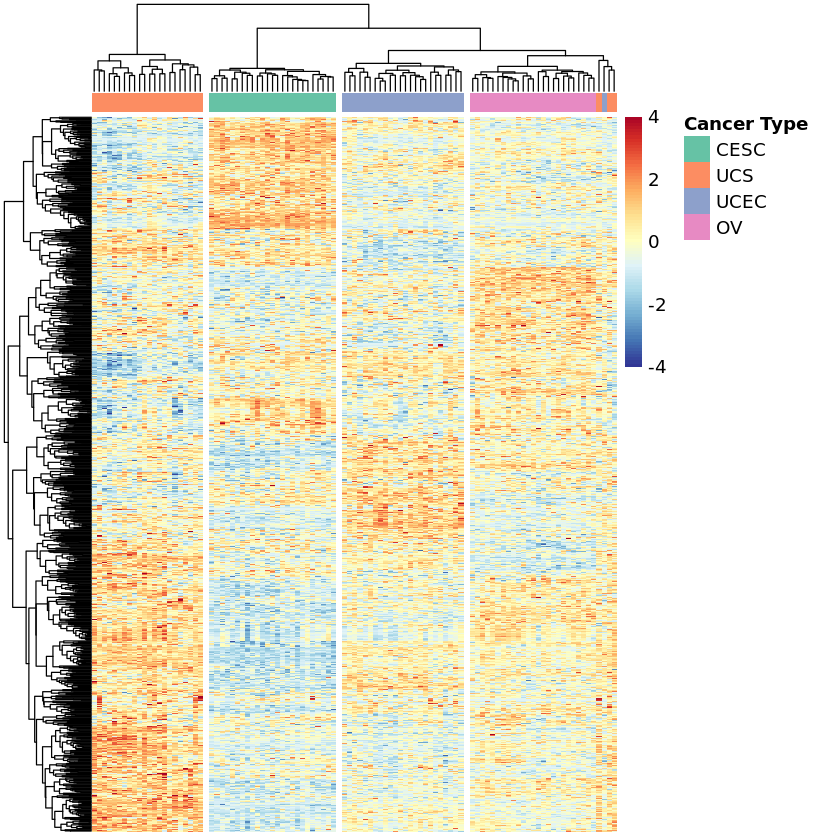

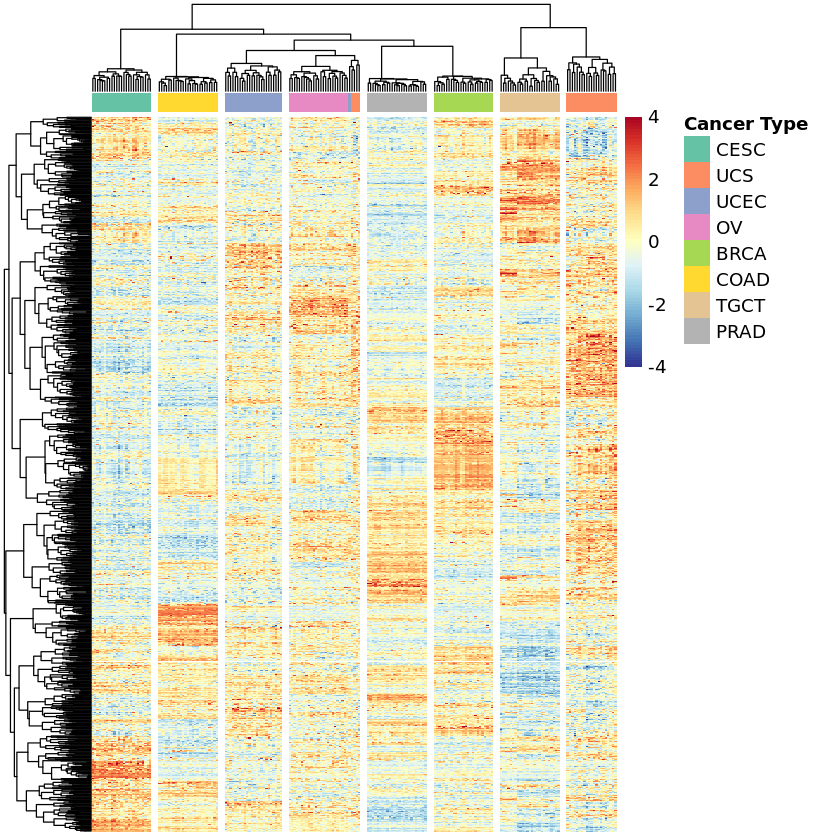

In [48]:
gyn_hm <- pheatmap(
    gyn_zscores,
    cluster_rows = gyn_clusts$row,
    cluster_cols = gyn_clusts$col,
    cutree_cols = length(gyn_projects),
    show_rownames = FALSE,
    show_colnames = FALSE,
    annotation_col = gyn_hm_ls$coldata["Cancer Type"],
    annotation_names_col = FALSE,
    annotation_colors = gyn_proj_colors,
    fontsize = text_size,
    legend = TRUE,
    color = pal,
    breaks = break_list
)
gyn_hm$gtable$grobs[[1]]$gp <- gpar(lwd = 0.5)
gyn_hm$gtable$grobs[[2]]$gp <- gpar(lwd = 0.5)

# plot_hm(gyn_hm, paste0(dirs$figures_dir, "/TCGA_overview/gyn_heatmap.png"))
ggsave(paste0(dirs$figures_dir, "/TCGA_overview/gyn_heatmap.png"), as.ggplot(gyn_hm), height = hm_ht, width = hm_wd, dpi = dpi)

pan_hm <- pheatmap(
    pan_zscores,
    cluster_rows = pan_clusts$row,
    cluster_cols = pan_clusts$col,
    cutree_cols = length(pan_projects),
    show_rownames = FALSE,
    show_colnames = FALSE,
    annotation_col = pan_hm_ls$coldata["Cancer Type"],
    annotation_names_col = FALSE,
    annotation_colors = pan_proj_colors,
    fontsize = text_size,
    legend = TRUE,
    color = pal,
    breaks = break_list
)
pan_hm$gtable$grobs[[1]]$gp <- gpar(lwd = 0.5)
pan_hm$gtable$grobs[[2]]$gp <- gpar(lwd = 0.5)

# plot_hm(pan_hm, paste0(dirs$figures_dir, "/TCGA_overview/pan_heatmap.png"))
ggsave(paste0(dirs$figures_dir, "/TCGA_overview/pan_heatmap.png"), as.ggplot(pan_hm), height = hm_ht, width = hm_wd, dpi = dpi)

# PCA

In [49]:
pan_pca_ls <- get_pca_results(pan_counts_df[, -1], pan_coldata_df)
gyn_pca_ls <- get_pca_results(gyn_counts_df[, -1], gyn_coldata_df)

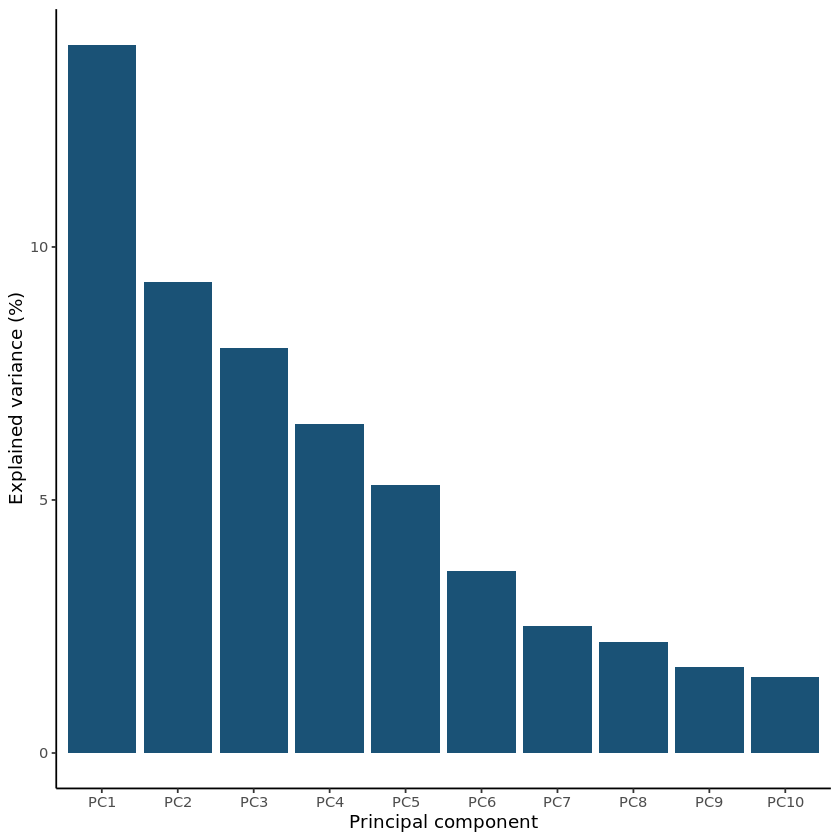

In [89]:
n_pcs <- 10
ggplot(head(pan_pca_ls$var, n_pcs)) +
    aes(x = factor(pc, levels = c(head(pan_pca_ls$var, n_pcs)$pc)), y = pct_var) +
    geom_bar(stat = "identity", fill = "#1A5276") + 
    theme_classic() +
    theme(
        text = element_text(size = text_size, family = family),
    ) +
    xlab("Principal component") +
    ylab("Explained variance (%)")
ggsave(filename = paste0(dirs$figures_dir, "/TCGA_overview/pan_screeplot.png"), last_plot(), height = scree_ht, width = scree_wd, dpi = dpi)

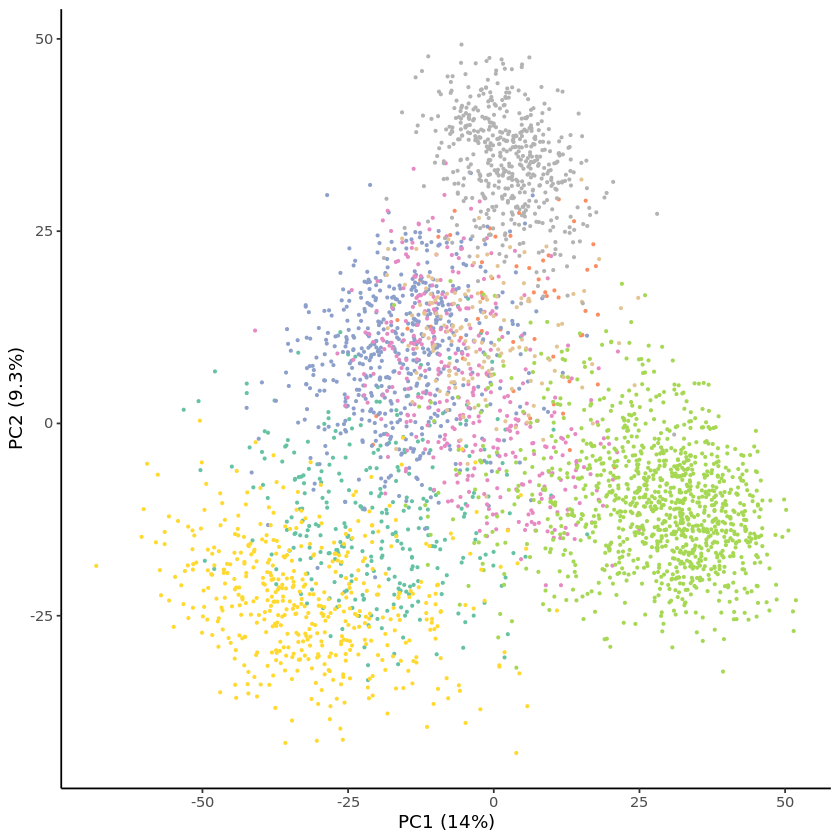

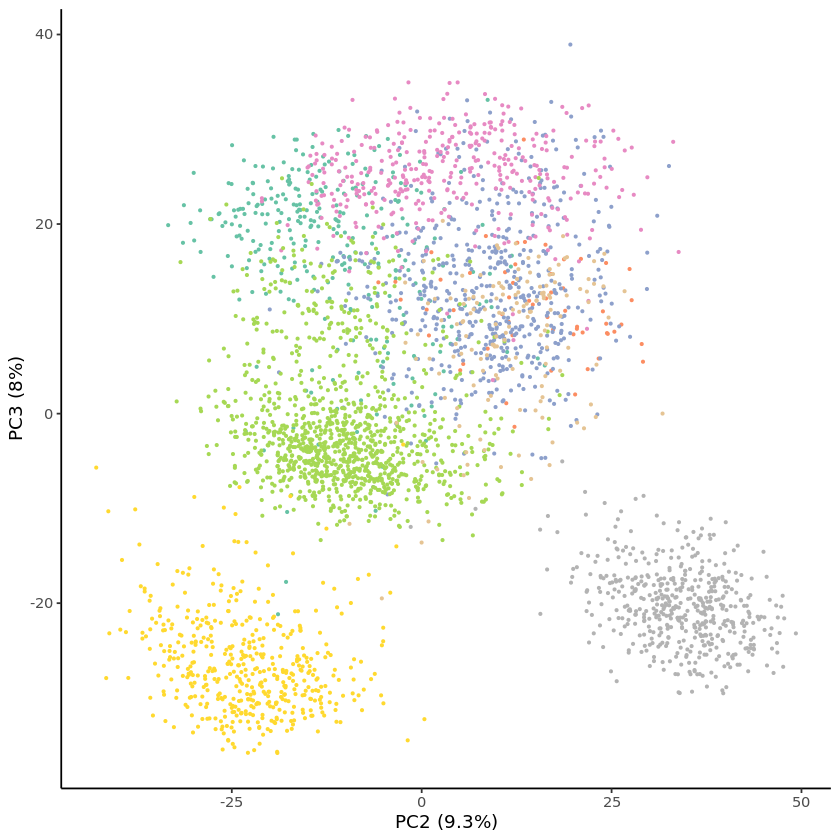

In [107]:
pca_scatter(
    pan_pca_ls$res, "PC1", "PC2", pan_pca_ls$var[1, ]$pct_var, pan_pca_ls$var[2, ]$pct_var,
    "project", legend_title = "Cancer Type", pt_size = 0.5,
    breaks = names(pan_proj_colors[["Cancer Type"]]),
    values = as.character(pan_proj_colors[["Cancer Type"]]),
    hide_legend = TRUE
)
ggsave(filename = paste0(dirs$figures_dir, "/TCGA_overview/pan_PC2_vs_PC1.png"), last_plot(), height = pca_ht, width = pca_wd)
pca_scatter(
    pan_pca_ls$res, "PC2", "PC3", pan_pca_ls$var[2, ]$pct_var, pan_pca_ls$var[3, ]$pct_var, "project",
    legend_title = "Cancer Type", pt_size = 0.5,
    breaks = names(pan_proj_colors[["Cancer Type"]]),
    values = as.character(pan_proj_colors[["Cancer Type"]]),
    hide_legend = TRUE
)
ggsave(filename = paste0(dirs$figures_dir, "/TCGA_overview/pan_PC3_vs_PC2.png"), last_plot(), height = pca_ht, width = pca_wd)

# pca_scatter(gyn_pca_ls$res, "PC1", "PC2", gyn_pca_ls$var[1, ]$pct_var, gyn_pca_ls$var[2, ]$pct_var, "project", legend_title = "Cancer Type")
# ggsave(filename = paste0(dirs$figures_dir, "/gyn_PC2_vs_PC1.png"), last_plot())
# pca_scatter(gyn_pca_ls$res, "PC2", "PC3", gyn_pca_ls$var[2, ]$pct_var, gyn_pca_ls$var[3, ]$pct_var, "project", legend_title = "Cancer Type")
# ggsave(filename = paste0(dirs$figures_dir, "/gyn_PC3_vs_PC2.png"), last_plot())

In [71]:
pan_pca_pivot_df <- pan_pca_ls$res %>%
    dplyr::select(sample_name, PC1:PC4, project) %>%
    pivot_longer(cols = PC1:PC4, names_to = "PC", values_to = "loadings") %>%
    mutate(proj_id = as.numeric(as.factor(project)))

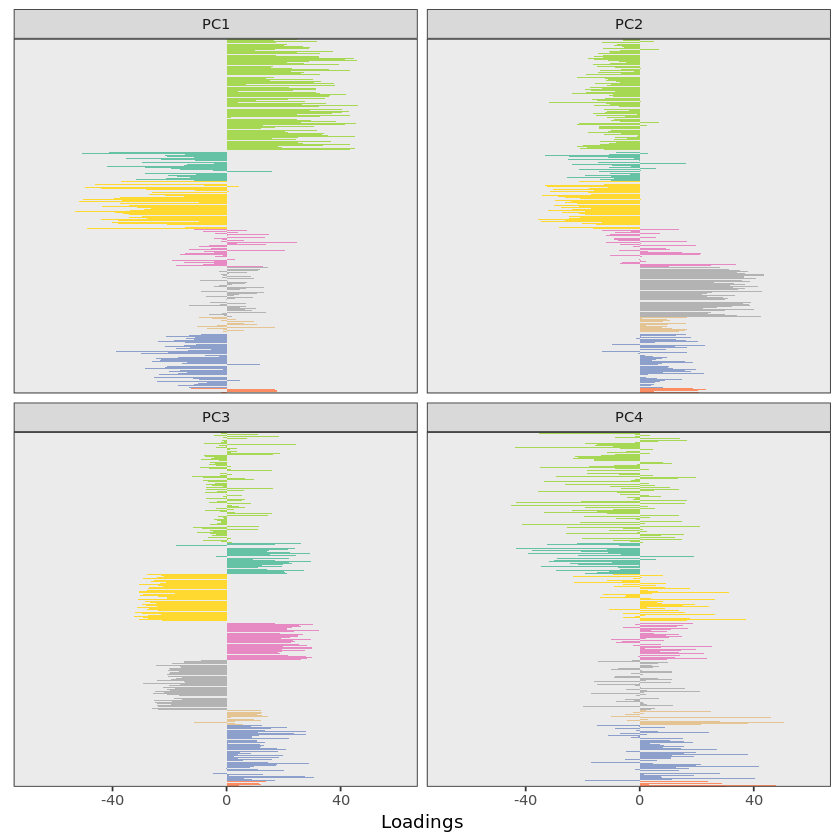

In [108]:
ggplot(pan_pca_pivot_df) +
    aes(x=reorder(sample_name, -proj_id), y=loadings, fill=project) +
    geom_bar(stat="identity") +
    scale_fill_manual(
        "Cancer Type",
        breaks = names(pan_proj_colors[["Cancer Type"]]),
        values = as.character(pan_proj_colors[["Cancer Type"]])
    ) +
    facet_wrap(~PC) +
    coord_flip() +
    theme_bw() + 
    theme(
        text = element_text(size = text_size, family = family),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank()
    ) +
    theme(legend.position = "none") +
    labs(y = "Loadings")
ggsave(filename = paste0(dirs$figures_dir, "/TCGA_overview/pan_small_multiples_plot.png"), last_plot(), height = sm_ht, width = sm_wd, dpi = dpi)

# UMAP

In [91]:
pan_umap_df <- get_umap_results(pan_counts_df[, -1], pan_coldata_df, random_state = 123)
gyn_umap_df <- get_umap_results(gyn_counts_df[, -1], gyn_coldata_df, random_state = 123)

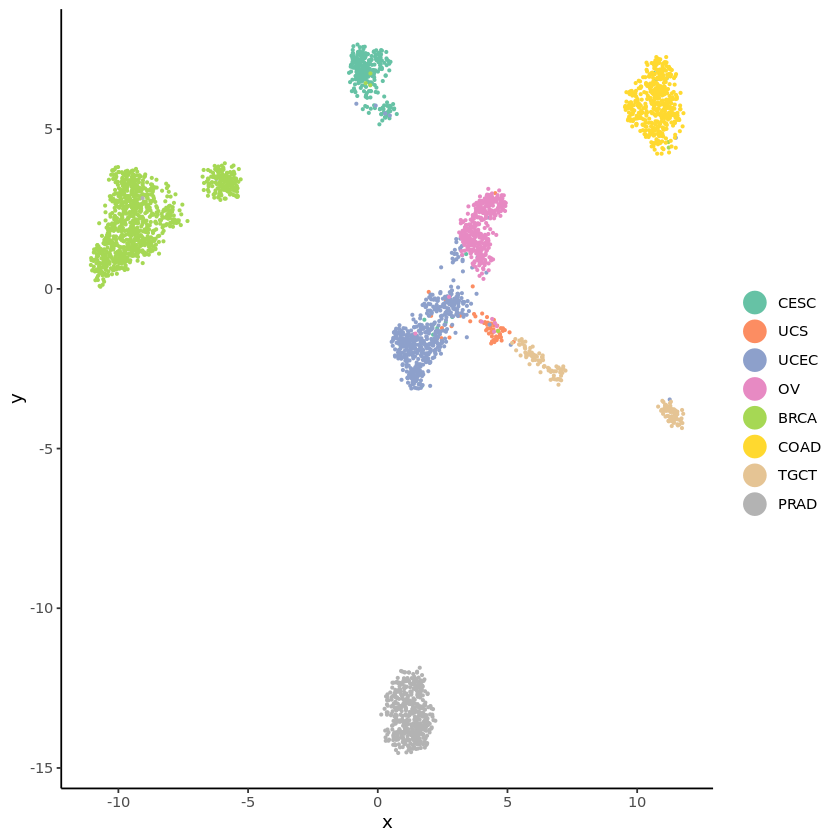

In [121]:
umap_scatter(
    pan_umap_df, "x1", "x2", "project",
    breaks = names(pan_proj_colors[["Cancer Type"]]),
    values = as.character(pan_proj_colors[["Cancer Type"]]),
    pt_size = 0.5, jitter_h = 0.25, jitter_w = 0.25, seed = 123,
    hide_legend = FALSE
)
ggsave(filename = paste0(dirs$figures_dir, "/TCGA_overview/pan_umap.png"), last_plot(), height = umap_ht, width = umap_wd, dpi = dpi)

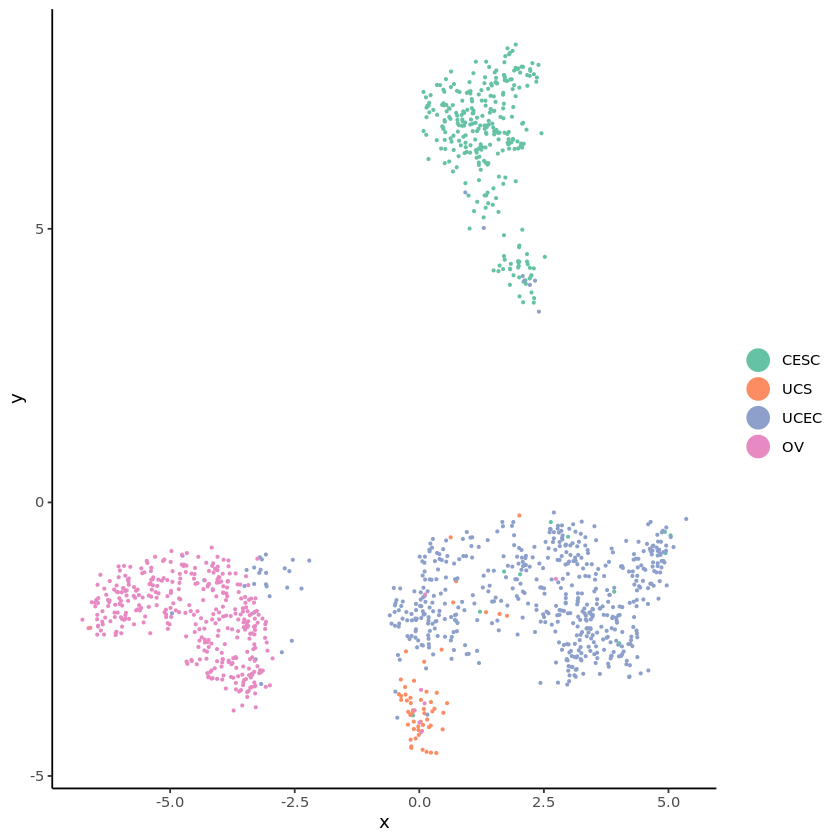

In [122]:
umap_scatter(
    gyn_umap_df, "x1", "x2", "project", 
    breaks = names(pan_proj_colors[["Cancer Type"]]), values = as.character(pan_proj_colors[["Cancer Type"]]), 
    pt_size = 0.5, jitter_h = 0.25, jitter_w = 0.25, seed = 123,
    hide_legend = FALSE
)
ggsave(filename = paste0(dirs$figures_dir, "/TCGA_overview/gyn_umap.png"), last_plot(), height = umap_ht, width = umap_wd, dpi = dpi)